# Computational Statistics 
# TP 3 : Hasting-Metropolis (and Gibbs) samplers

## Exercice 1 : Hasting-Metropolis within Gibbs – Stochastic Approximation EM

### Question 1

Réponse sur feuille.

### Question 2

In [1]:
import numpy as np
from scipy.stats import invwishart
import matplotlib.pyplot as plt
from scipy import stats, optimize, interpolate
np.random.seed(27)

In [2]:
#Average trajectory
def d(t, p0, v0, t0):
  return p0 + v0 * (t - t0)

In [3]:
#Parameters fixed
sigma_t0 = 0.1
sigma_v0 = 0.1

s_t0 = 0.1
s_v0 = 0.1
t0_bar2 = 1 #mean of mean of t0
v0_bar2 = 1
v_ksi = 2
m_ksi = 6
v_tau = 2
m_tau = 6
v = 2
m = 6

#Parameters to generate
t0_bar = np.random.normal(t0_bar2, sigma_t0, 1)
v0_bar = np.random.normal(v0_bar2, sigma_v0, 1)
sigma_ksi = invwishart(v_ksi, m_ksi).rvs(size=1) ** (1/2)
sigma_tau = invwishart(v_tau, m_tau).rvs(size=1) ** (1/2)
sigma = invwishart(v, m).rvs(size=1) ** (1/2)


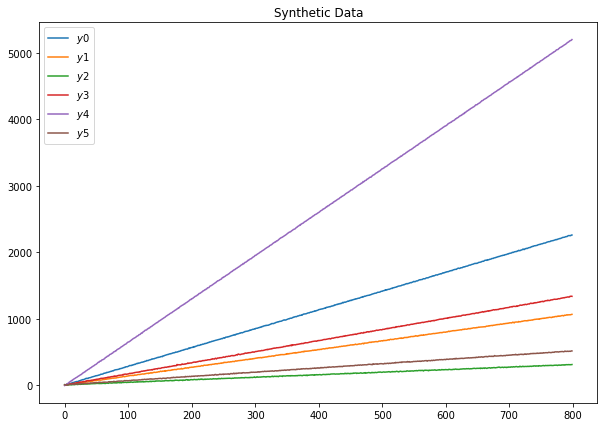

In [4]:
N = 10
K = 800
y = np.zeros((N,K))

t0 = np.random.normal(t0_bar, sigma_t0, 1)
v0 = np.random.normal(v0_bar, sigma_v0, 1)
p0 = 10 #We fix p0

for i in range(N):
  ksi = np.random.normal(0, sigma_ksi, 1)
  alpha = np.exp(ksi)
  tau = np.random.normal(0, sigma_tau, 1)
  for j in range(K):
    t_i_j = j
    eps = np.random.normal(0, sigma, 1)
    t = alpha * (t_i_j - t0 - tau) + t0
    y[i,j] = d(t, p0, v0, t0) + eps

plt.figure(figsize=(10,7))
for i in range(6):
    plt.plot(np.arange(K), y[i,:] , label = '$y$' + str(i))

plt.title('Synthetic Data')
plt.legend()
plt.show()


### Question 3

Explication de la formule de $\pi$(z) sur feuille.

In [5]:
def log_p(y, z, p0, t0, v0, t, mean_t0, mean_v0, sigma_t0, sigma_v0, sigma_prop_ksi, sigma_prop_tau):
    
    t0, v0 = z[0:2]
    ksi = z[2:N+2].reshape(-1, 1)  #Convert to Nx1
    tau = z[N+2:].reshape(-1, 1)  #Convert to Nx1
    
    ti = np.exp(ksi) * (t - t0 - tau) 
    log_p_y = -np.sum((y - d(ti + t0, p0, v0, t0)) **2)
    
    log_p_z = -(np.sum(ksi ** 2) / (2 * sigma_prop_ksi **  2) - np.sum(tau ** 2) / (2 * sigma_prop_tau ** 2) - (t0 - mean_t0) ** 2 / (2 * sigma_t0 ** 2) - (v0 - mean_v0) ** 2 / (2 * sigma_v0 ** 2))
    
    log_p = log_p_y + log_p_z

    return log_p


def SRWHM(y, z, p0, t0, v0, mean_t0, mean_v0, sigma_t0, sigma_v0, sigma_prop_ksi, sigma_prop_tau, N, maxIter=10000):

    #Multivariate gaussian
    mean_prop = [mean_t0, mean_v0] + (2 * N) * [0]
    cov_prop = [sigma_t0, sigma_v0] + [sigma_prop_ksi] * N +  [sigma_prop_tau] * N
    cov_prop = cov_prop = 0.005 * np.eye(2 * N + 2) * cov_prop
    
    #Initial state z0
    Z = [z]
    t = np.arange(K).reshape(1, -1)  # (1, K)
    
    for k in range(maxIter):

        zk = np.random.multivariate_normal(mean=z, cov=cov_prop)
        
        #pi(Z(k))
        log_p_zk = log_p(y, zk, p0, t0, v0, t, mean_t0, mean_v0, sigma_t0, sigma_v0, sigma_prop_ksi, sigma_prop_tau)

        #pi(Z*)
        log_p_z = log_p(y, z, p0, t0, v0, t, mean_t0, mean_v0, sigma_t0, sigma_v0, sigma_prop_ksi, sigma_prop_tau)

        #Acceptance-Rejection
        log_alpha = min(0, log_p_z - log_p_zk)
        log_u = np.log(np.random.rand())
        
        if log_u - log_alpha < 0:
            z = zk.copy()
        Z.append(z)

    return Z

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-5-0bbc1a77f55f>:39: RuntimeWarning: invalid value encountered in subtract
  log_alpha = min(0, log_p_z - log_p_zk)


Mean of t0 :  [1.12856054]


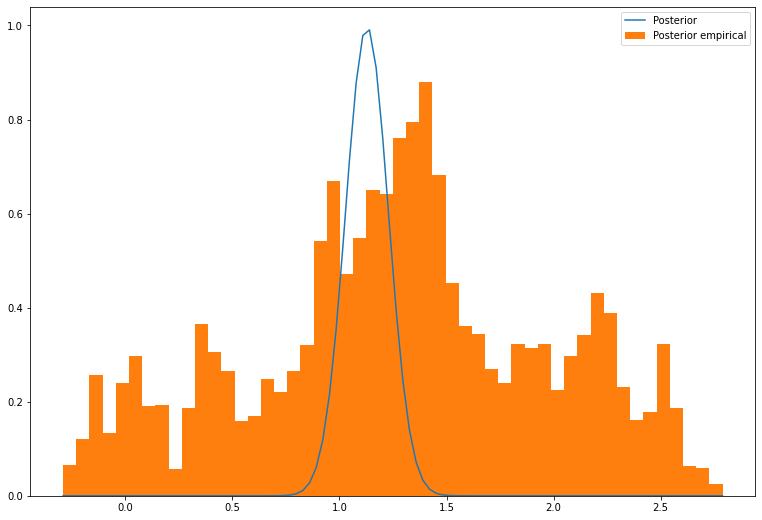

In [6]:
np.random.seed(6)

z = np.random.random(2 * N + 2)

sigma_prop_ksi = sigma_ksi
sigma_prop_tau = sigma_tau

z_list = SRWHM(y, z, p0, t0, v0, t0_bar, v0_bar, sigma_t0, sigma_v0, sigma_prop_ksi, sigma_prop_tau, N)

t0_list = [z_list[i][0] for i in range(len(z_list))]
mean_t0 = t0_bar
sigma_t0 = s_t0

print("Mean of t0 : ", mean_t0)

min_t0 = min(t0_list)
max_t0 = max(t0_list)

X = np.linspace(min_t0, max_t0, 100)
Y = np.asarray([stats.norm.pdf(x, loc=mean_t0, scale=sigma_t0) for x in X])
Y = Y / 4

plt.figure(figsize=(13,9))
plt.plot(X, Y, label="Posterior")
plt.hist(t0_list, bins=50, density=True, stacked=True, label="Posterior empirical")
plt.legend()
plt.show()


On remarque d'après la figure précèdent que la posterior distribution approximé est proche de celle théorique (courbe en bleu), on a également un pic autour de la moyenne de t0 à 1.12 environ. Donc l'algorithme MH semble générer un échantillon qui se rapproche d'un échantillon issu de la posterior distribution.

## Exercice 2 : Multiplicative Hasting-Metropolis

### Question 1-2

Réponse sur feuille.

### Question 3

In [7]:
A = stats.norm.pdf(1, 0, 1)
print(A)

0.24197072451914337


In [8]:
#On choisi une loi exponentielle de parametre L pour le premier echantillon
def MH_exp(x0, N, L):
  x = x0
  X = [x]
  for k in range(N):

    B = np.random.binomial(1,1/2,1)[0]
    eps = np.random.uniform(-1,1)

    if B == 1:
      Y = eps * x
    else:
      Y = x / eps
    
    U = np.random.uniform()
    pi_X = stats.expon.pdf(x, 0, L)
    pi_Y = stats.expon.pdf(Y, 0, L)

    alpha = min(1, (pi_Y * np.abs(Y))/(pi_X * np.abs(x)))
    
    if U < alpha:
      x = Y
    X.append(x)
  return X

In [9]:
#On choisi une loi normale pour le second echantillon
def MH_norm(x0, N, mu, sigma):
  x = x0
  X = [x]
  for k in range(N):

    B = np.random.binomial(1,1/2,1)[0]
    eps = np.random.uniform(-1,1)

    if B == 1:
      Y = eps * x
    else:
      Y = x / eps
    
    U = np.random.uniform()
    pi_X = stats.norm.pdf(x, mu, sigma)
    pi_Y = stats.norm.pdf(Y, mu, sigma)

    alpha = min(1, (pi_Y * np.abs(Y))/(pi_X * np.abs(x)))
    
    if U < alpha:
      x = Y
    X.append(x)
  return X

### Question 4

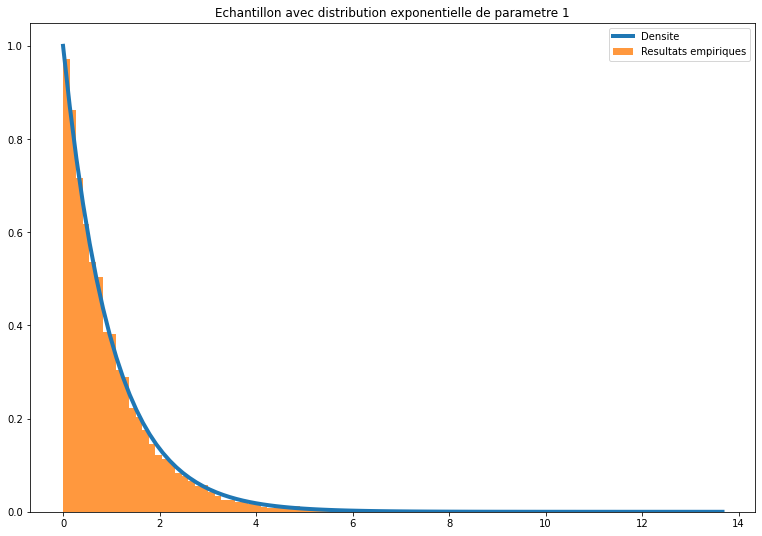

In [10]:
#Pour la distribution exponentielle
L = 1
N = 50000
X = MH_exp(1, N, L)
x = np.linspace(min(X), max(X), 100)
exp = stats.expon.pdf(x, 0, 1)

plt.figure(figsize=(13,9))
plt.plot(x, exp, linewidth=4, label= 'Densite')
plt.hist(X, bins=100, density=True, alpha=0.8, label='Resultats empiriques')
plt.title('Echantillon avec distribution exponentielle de parametre ' + str(L))

plt.legend()
plt.show()

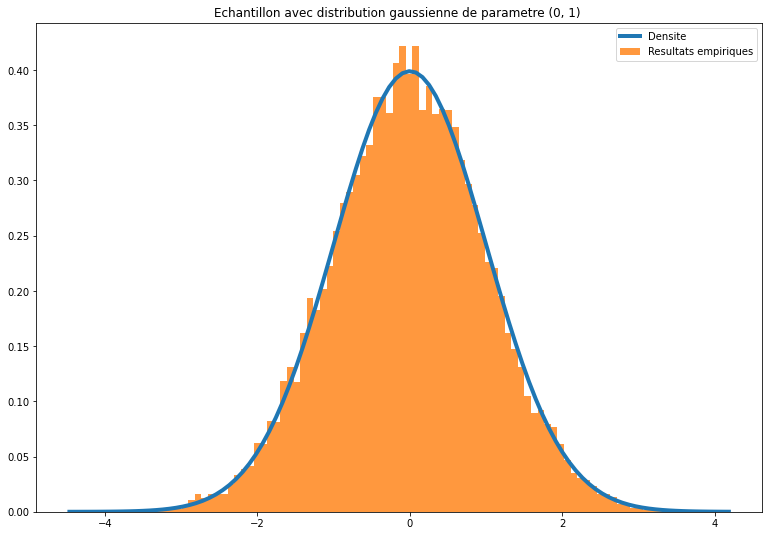

In [11]:
#Pour la distribution gaussienne
mu = 0
sigma = 1
N = 50000
X = MH_norm(1, N, mu, sigma)
x = np.linspace(min(X), max(X), 100)
exp = stats.norm.pdf(x, mu, sigma)

plt.figure(figsize=(13,9))
plt.plot(x, exp, linewidth=4, label= 'Densite')
plt.hist(X, bins=100, density=True, alpha=0.8, label='Resultats empiriques')

plt.title('Echantillon avec distribution gaussienne de parametre (' + str(mu) + ', ' + str(sigma) + ') ')
plt.legend()
plt.show()

On en conclut que nos échantillons générés par nos algorithmes MH concordent avec les densités théoriques attendues.

## Exercice 3 : Data augmentation

### Question 1-2

Réponse sur feuille.

### Question 3

Réponse sur feuille + code :

In [33]:
from scipy.special import gamma

def gibbs_sampler(X0, Y0, N):
  Xn = X0
  Yn = Y0
  X = np.zeros(N)
  Y = np.zeros(N)
  X[0] = Xn
  Y[0] = Yn
  for n in range(1, N):
    Xn =  np.random.normal(0, 1/np.sqrt(Yn), 1)
    X[n] = Xn
    Beta = ((Xn**2)/2) + 2 
    Yn = np.random.gamma(shape=5/2, scale=1/Beta, size=1)
    Y[n] = Yn
  return X, Y

def fX(x):
  Beta = ((x**2)/2) + 2
  return (4*gamma(5/2))/(np.sqrt(2*np.pi) * Beta**(5/2))

def fY(y):
  if(y>=0):
    return 4*y*np.exp(-2*y)*(y>=0)
  else: 
    return 0

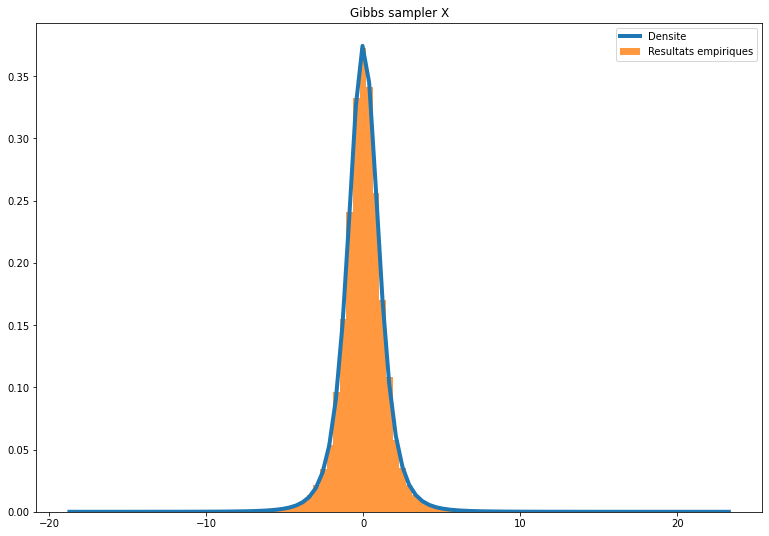

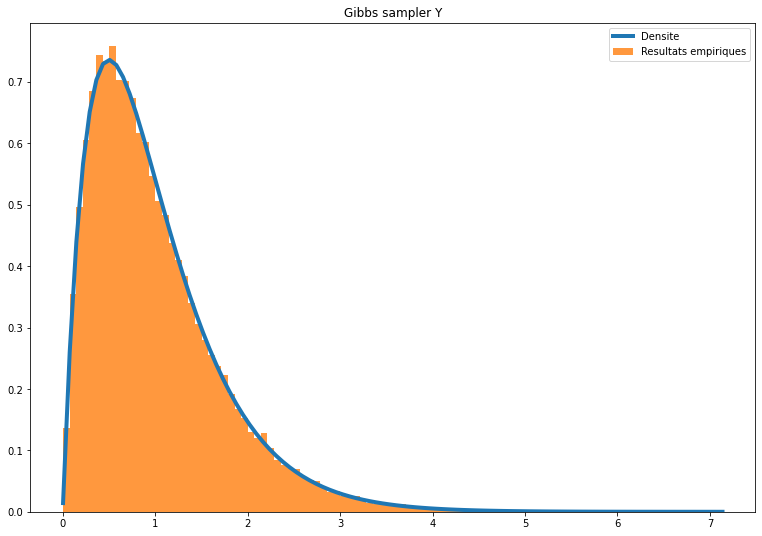

In [38]:
X0 = 1
Y0 = 1
N = 50000
X, Y = gibbs_sampler(X0, Y0, N)

#Pour l'echantillon des Xn
x = np.linspace(min(X), max(X), 100)

plt.figure(figsize=(13,9))
plt.plot(x, fX(x), linewidth=4, label= 'Densite')
plt.hist(X, bins=100, density=True, alpha=0.8, label='Resultats empiriques')

plt.title('Gibbs sampler X')
plt.legend()
plt.show()

#Pour l'echantillon des Yn
x = np.linspace(min(Y), max(Y), 100)

y = np.zeros(len(x))
for k in range(len(x)):
  y[k] = fY(x[k])

plt.figure(figsize=(13,9))
plt.plot(x, y, linewidth=4, label= 'Densite')
plt.hist(Y, bins=100, density=True, alpha=0.8, label='Resultats empiriques')

plt.title('Gibbs sampler Y')
plt.legend()
plt.show()

On remarque que les approximations par l'algorithme de Gibbs sampler sont cohérentes avec les densités théoriques.

### Question 4

Réponse sur feuille.